In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#plt.style.use("seaborn")
%matplotlib inline

import warnings
warnings.simplefilter("ignore")
from binance.client import Client
import time
import statistics as stats
from datetime import datetime
import random
import torch
import torch.nn as nn
import mlfinlab
import glob

In [2]:
#choose cuda if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
#target currency /BTC
coin_list=['ADA', 'BNB', 'ETH', 'LINK', 'LTC', 'XRP']

In [4]:
#stored_tensors
tensor_files='E:/Users/Justin/Desktop/Course Folders 2020/practicum/tensors/25_price'

In [5]:
#stored weights
weights_path='E:/Users/Justin/Desktop/Course Folders 2020/practicum/weights/model/'
best_weights_path='E:/Users/Justin/Desktop/Course Folders 2020/practicum/weights/best_model'

In [6]:
#loads pth files that contain the tensors for training and testing
li=[]

all_files = glob.glob(tensor_files + "/*.pth")
for i in range(len(all_files)):
    
    x=torch.load(all_files[i])
    li.append(x)


In [7]:
class LSTM(nn.Module):

    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True).to(device)
        self.l1 = nn.Linear(hidden_dim, output_dim).to(device)
        self.drop = nn.Dropout(.2)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_dim).requires_grad_()
        output, hidden_state = self.lstm(x.to(device), (h0.detach().to(device), c0.detach().to(device)))
        lstm_out = self.relu(output[:, -1, :])
        out = self.l1(lstm_out)
        return out

In [8]:
class Net(nn.Module):
    def __init__(self, input_size, output_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 300)
        self.fc2 = nn.Linear(300, 150)
        self.fc3 = nn.Linear(150, 60)
        self.fc4 = nn.Linear(60, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.sigmoid(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return self.sigmoid(self.fc4(x))

In [9]:
class GRU(nn.Module):

    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.l1 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_dim).requires_grad_()
        output, hn = self.gru(x.to(device), h0.detach().to(device)) 
        out = self.l1(output[:, -1, :])
        return out

In [10]:
coin='XRP'
test = li[1][coin]

In [11]:
training_data = test[0]

In [12]:
testing_data = test[1]

In [13]:
print(training_data[0].shape)
print(training_data[1].shape)

torch.Size([44935, 24, 1])
torch.Size([44935, 1])


In [14]:
print(testing_data[0].shape)
print(testing_data[1].shape)

torch.Size([2618, 24, 1])
torch.Size([2618, 1])


In [15]:
x_train=training_data[0]
y_train=training_data[1]
x_test=testing_data[0]
y_test=testing_data[1]

In [16]:
def min_max_scaling(x):
    return (x-torch.min(x))/(torch.max(x)-torch.min(x))

In [17]:
input_dim = 1
hidden_dim = 32
n_layers = 2
output_dim = 1

model = LSTM(input_dim, hidden_dim, n_layers, output_dim)
#model = GRU(input_dim, hidden_dim, n_layers, output_dim)
model.to(device)

#criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss(size_average=True)

#optimizer = torch.optim.SGD(model.parameters(), lr=.1)
optimizer = torch.optim.Adam(model.parameters(), lr=.01)

In [18]:
torch.cuda.empty_cache()

## Training

In [19]:
#'''
epochs=2500
time_list=[]
loss_list=[]
torch.cuda.empty_cache()
model.train()

for i in range(epochs):
    
    start=time.time()
    
    #k=batch_size
    indices=random.sample(list(range(20_000, x_train.shape[0])), k=500)
    
    sequence=x_train[indices].to(device)
    label=y_train[indices].to(device) 
    
    optimizer.zero_grad()
    prediction=model(sequence)
    loss=criterion(prediction, label)
    
    loss_list.append(loss.item())
    
    #model.zero_grad()
    loss.backward()
    optimizer.step()
    
    end=time.time()
    
    if i%50==0 or i==epochs-1:
        torch.save(model.state_dict(), weights_path+'_'+coin+'.pth')
    
    time_list.append(end-start)
    
    if i%100==0:
        print('Epoch: ', i, 'Time: ', time_list[-1], 'Loss: ', loss_list[-1])
#'''

Epoch:  0 Time:  0.2503483295440674 Loss:  0.001738796359859407
Epoch:  100 Time:  0.010971307754516602 Loss:  5.0863184775096215e-09
Epoch:  200 Time:  0.012966156005859375 Loss:  5.413880455051867e-10
Epoch:  300 Time:  0.00997304916381836 Loss:  5.485568665974938e-10
Epoch:  400 Time:  0.008975505828857422 Loss:  5.218323551048343e-10
Epoch:  500 Time:  0.01196742057800293 Loss:  5.059477281577074e-10
Epoch:  600 Time:  0.009974241256713867 Loss:  5.032869676568907e-10
Epoch:  700 Time:  0.011968135833740234 Loss:  4.698159639104915e-10
Epoch:  800 Time:  0.011968612670898438 Loss:  5.214832454747409e-10
Epoch:  900 Time:  0.009973287582397461 Loss:  5.199075059358904e-10
Epoch:  1000 Time:  0.009972333908081055 Loss:  4.860858382471633e-10
Epoch:  1100 Time:  0.011968851089477539 Loss:  5.471551545177533e-10
Epoch:  1200 Time:  0.009973287582397461 Loss:  4.951743459713498e-10
Epoch:  1300 Time:  0.009973764419555664 Loss:  5.910500977535094e-10
Epoch:  1400 Time:  0.00997233390808

In [20]:
'''
epochs=100
time_list=[]
loss_list=[]
torch.cuda.empty_cache()
model.train()

for i in range(epochs):
    
    start=time.time()
    
    sequence=x_train[20000:].to(device)
    label=y_train[20000:].to(device)
    
    optimizer.zero_grad()
    prediction=model(sequence)
    loss=criterion(prediction, label)
    
    loss_list.append(loss.item())
    
    #model.zero_grad()
    loss.backward()
    optimizer.step()
    
    if i%2==0 or i==epochs-1:
        #saving=(i,optimizer,criterion,model.state_dict(),model)
        torch.save(model.state_dict(), weights_path+coin+'.pth')
    
    end=time.time()
    
    time_list.append(end-start)
    
    print('Epoch: ', i, 'Time: ', time_list[-1], 'Loss: ', loss_list[-1])
#'''

"\nepochs=100\ntime_list=[]\nloss_list=[]\ntorch.cuda.empty_cache()\nmodel.train()\n\nfor i in range(epochs):\n    \n    start=time.time()\n    \n    sequence=x_train[20000:].to(device)\n    label=y_train[20000:].to(device)\n    \n    optimizer.zero_grad()\n    prediction=model(sequence)\n    loss=criterion(prediction, label)\n    \n    loss_list.append(loss.item())\n    \n    #model.zero_grad()\n    loss.backward()\n    optimizer.step()\n    \n    if i%2==0 or i==epochs-1:\n        #saving=(i,optimizer,criterion,model.state_dict(),model)\n        torch.save(model.state_dict(), weights_path+coin+'.pth')\n    \n    end=time.time()\n    \n    time_list.append(end-start)\n    \n    print('Epoch: ', i, 'Time: ', time_list[-1], 'Loss: ', loss_list[-1])\n#"

## Testing

In [21]:
#model.eval()
with torch.no_grad():
    trained_predictions=model(x_test)

In [22]:
trained_ratios=[1]
for i in range(1, trained_predictions.shape[0]):
    trained_ratios.append(trained_predictions[i]/trained_predictions[i-1] - 1)

In [23]:
test_ratios=[1]
for i in range(1, y_test.shape[0]):
    test_ratios.append(y_test[i]/y_test[i-1] - 1)

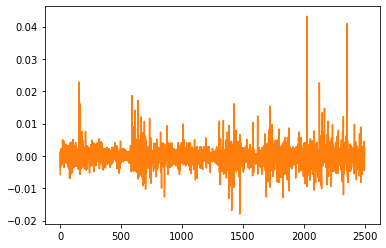

In [24]:
plt.plot(trained_ratios[1:2500])
plt.plot(test_ratios[1:2500])

plt.show()

In [25]:
trained_predictions.shape

torch.Size([2618, 1])

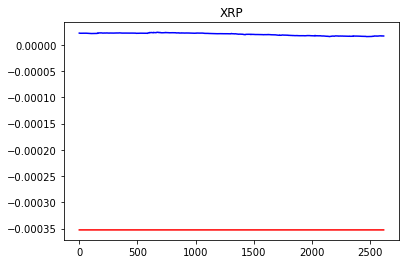

In [26]:
plt.plot(trained_predictions.cpu().detach().numpy(), color='r')
plt.plot(y_test, color='b')
plt.title(coin)

plt.show()

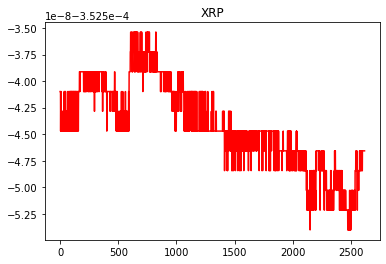

In [27]:
plt.plot(trained_predictions.cpu().detach().numpy(), color='r')
plt.title(coin)

plt.show()

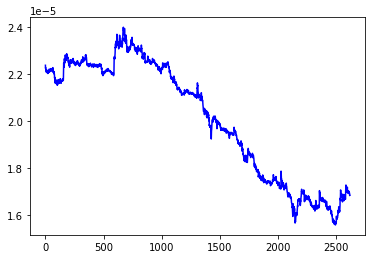

In [28]:
plt.plot(y_test, color='b')

## Normalization

In [29]:
x_train_normalized=min_max_scaling(x_train)

In [30]:
input_dim = 1
hidden_dim = 32
n_layers = 2
output_dim = 1

model = LSTM(input_dim, hidden_dim, n_layers, output_dim)
#model = GRU(input_dim, hidden_dim, n_layers, output_dim)
model.to(device)

#criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss(size_average=True)

#optimizer = torch.optim.SGD(model.parameters(), lr=.1)
optimizer = torch.optim.Adam(model.parameters(), lr=.001)

In [31]:
#'''
epochs=1000
time_list=[]
loss_list=[]
torch.cuda.empty_cache()
model.train()

for i in range(epochs):
    
    start=time.time()
    
    #k=batch_size
    indices=random.sample(list(range(20_000, x_train_normalized.shape[0])), k=5_000)
    
    sequence=x_train_normalized[indices].to(device)
    label=y_train[indices].to(device)
    
    
    optimizer.zero_grad()
    prediction=model(sequence)
    loss=criterion(prediction, label)
    
    loss_list.append(loss.item())
    
    #model.zero_grad()
    loss.backward()
    optimizer.step()
    
    if i%5==0 or i==epochs-1:
        torch.save(model.state_dict(), weights_path+'_normalized_'+coin+'.pth')
    
    end=time.time()
    
    time_list.append(end-start)
    
    if i%50==0:
        print('Epoch: ', i, 'Time: ', time_list[-1], 'Loss: ', loss_list[-1])
#'''

Epoch:  0 Time:  0.06881546974182129 Loss:  0.0017586442409083247
Epoch:  50 Time:  0.05186271667480469 Loss:  5.264709557195602e-07
Epoch:  100 Time:  0.048453569412231445 Loss:  2.0461920158254543e-08
Epoch:  150 Time:  0.045877933502197266 Loss:  1.0317771526047181e-08
Epoch:  200 Time:  0.044879913330078125 Loss:  4.881854032134925e-09
Epoch:  250 Time:  0.0468747615814209 Loss:  2.0831494307316234e-09
Epoch:  300 Time:  0.04787182807922363 Loss:  7.805064927701721e-10
Epoch:  350 Time:  0.05784463882446289 Loss:  2.5820245941332587e-10
Epoch:  400 Time:  0.0468745231628418 Loss:  7.404421520362803e-11
Epoch:  450 Time:  0.04587864875793457 Loss:  2.013757043062281e-11
Epoch:  500 Time:  0.047380685806274414 Loss:  4.666024511212896e-12
Epoch:  550 Time:  0.08976197242736816 Loss:  1.0778395320362733e-12
Epoch:  600 Time:  0.0443878173828125 Loss:  3.1844828423527316e-13
Epoch:  650 Time:  0.04886889457702637 Loss:  1.7110546649250907e-13
Epoch:  700 Time:  0.06333613395690918 Loss

In [32]:
'''
#epochs=5_000
epochs=50
time_list=[]
loss_list=[]
torch.cuda.empty_cache()
model.train()

for i in range(epochs):
    
    start=time.time()
    
    sequence=x_train_normalized[20000:].to(device)
    label=y_train[20000:].to(device)
    
    optimizer.zero_grad()
    prediction=model(sequence)
    loss=criterion(prediction, label)
    
    loss_list.append(loss.item())
    
    #model.zero_grad()
    loss.backward()
    optimizer.step()
    
    end=time.time()
    
    if i%2==0 or i==epochs-1:
        torch.save(model.state_dict(), weights_path+'_normalized_'+coin+'.pth')
        
    time_list.append(end-start)
    
    print('Epoch: ', i, 'Time: ', time_list[-1], 'Loss: ', loss_list[-1])
#'''

"\n#epochs=5_000\nepochs=50\ntime_list=[]\nloss_list=[]\ntorch.cuda.empty_cache()\nmodel.train()\n\nfor i in range(epochs):\n    \n    start=time.time()\n    \n    sequence=x_train_normalized[20000:].to(device)\n    label=y_train[20000:].to(device)\n    \n    optimizer.zero_grad()\n    prediction=model(sequence)\n    loss=criterion(prediction, label)\n    \n    loss_list.append(loss.item())\n    \n    #model.zero_grad()\n    loss.backward()\n    optimizer.step()\n    \n    end=time.time()\n    \n    if i%2==0 or i==epochs-1:\n        torch.save(model.state_dict(), weights_path+'_normalized_'+coin+'.pth')\n        \n    time_list.append(end-start)\n    \n    print('Epoch: ', i, 'Time: ', time_list[-1], 'Loss: ', loss_list[-1])\n#"

In [33]:
x_test_normalized=min_max_scaling(x_test)

In [34]:
model.eval()
with torch.no_grad():
    trained_predictions=model(x_test_normalized)

In [35]:
trained_ratios=[1]
for i in range(1, trained_predictions.shape[0]):
    trained_ratios.append(trained_predictions[i]/trained_predictions[i-1] - 1)

In [36]:
test_ratios=[1]
for i in range(1, y_test.shape[0]):
    test_ratios.append(y_test[i]/y_test[i-1] - 1)

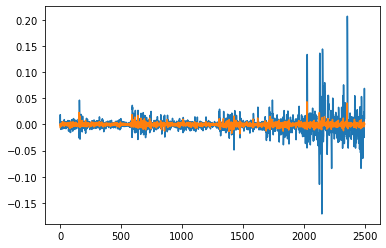

In [37]:
plt.plot(trained_ratios[1:2500])
plt.plot(test_ratios[1:2500])

plt.show()

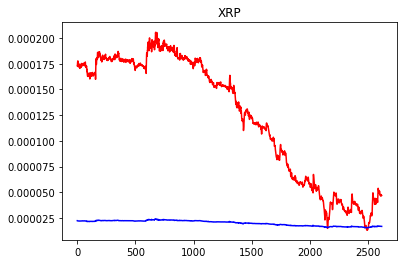

In [38]:
plt.plot(trained_predictions.cpu().detach().numpy(), color='r')
plt.plot(y_test, color='b')
plt.title(coin)

plt.show()

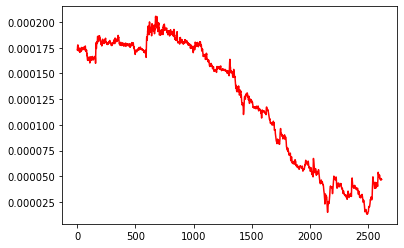

In [39]:
plt.plot(trained_predictions.cpu().detach().numpy(), color='r')

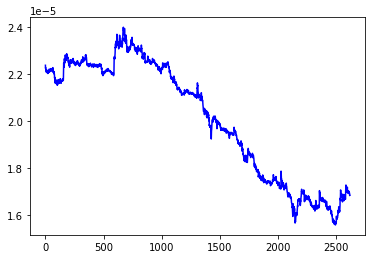

In [40]:
plt.plot(y_test, color='b')

In [41]:
'''
## normalizing benefits:
    ADA, LINK, XRP
## non-normalization:
    BNB, ETH
## can capture the shape doing both, not normalizing closer to price approximation 
    BNB, ETH, LINK, LTC  
''' 

'\n## normalizing benefits:\n    ADA, LINK, XRP\n## non-normalization:\n    BNB, ETH, \n## can capture the shape doing both, not normalizing closer to price approximation \n    BNB, ETH, LINK, LTC  \n'